#Tea Disease Prediction for AgroAI  
## Model 5: ResNet50
### Import Dependencies

In [1]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

### Load Images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FINAL_PROJECT/Tea.zip", 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [4]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 64
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [5]:
# Set up the base directory
base_dir = "/content/data/"

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 28824 files belonging to 6 classes.


In [7]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [8]:
classes = dataset.class_names
classes

['tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented']

In [9]:
len(dataset)

451

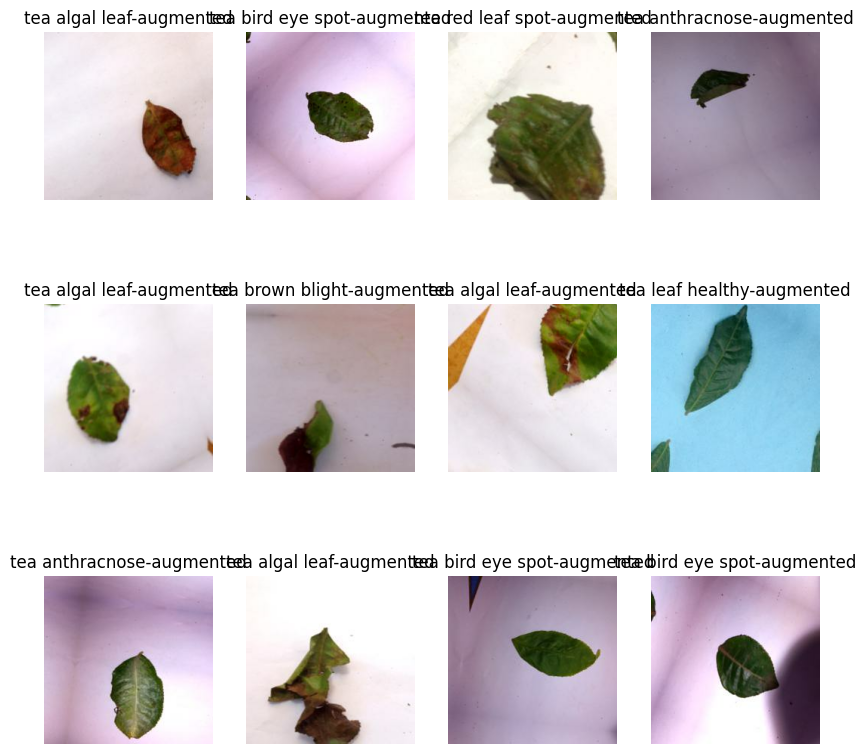

In [10]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [11]:
len(dataset) * 64

28864

### Data Splitting

In [12]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = data_split(dataset)

In [14]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 360

Length of Validation Dataset is 67

Length of Testing Dataset is 24


### Image Augmentation

In [15]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
type(train_ds)

tensorflow.python.data.ops.take_op._TakeDataset

In [17]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [18]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [19]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

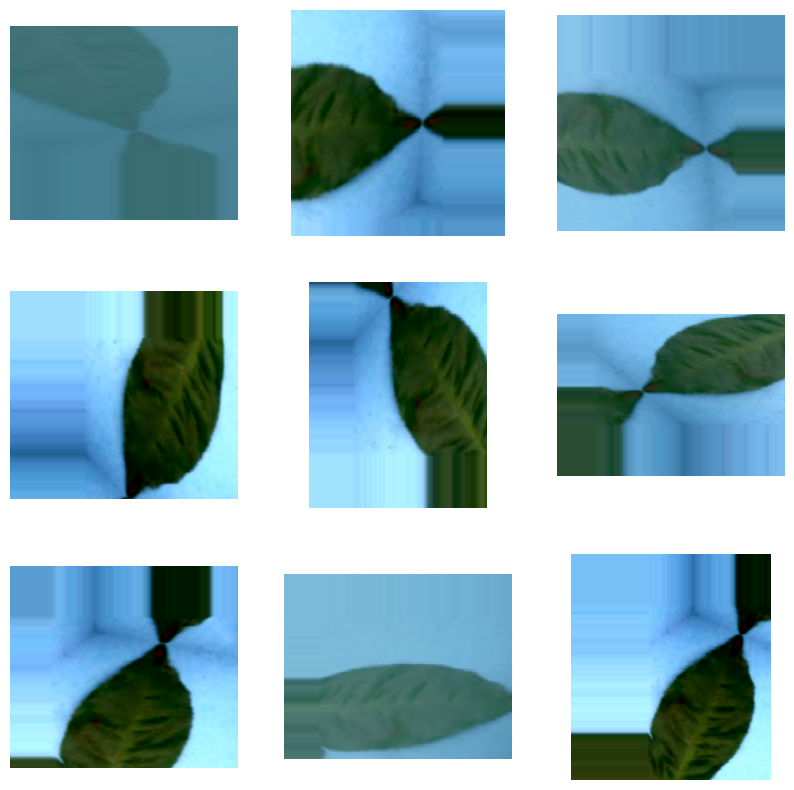

In [20]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [21]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [22]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

### Model 5: ResNet50

In [23]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(64, 224, 224, 3)


In [24]:
len(classes)

6

In [25]:
from tensorflow.keras.applications.resnet import ResNet50

pre_trained_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in pre_trained_model.layers[:-15]:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [26]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [27]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(6, activation = 'softmax')(x)

model5 = tf.keras.Model(inputs = inputs, outputs = predict)
#model5 = tf.keras.Model(inputs = pre_trained_model.input, outputs = predict)

In [28]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0     

In [29]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
        elif(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True

callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [30]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [31]:
history5 = model5.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
360/360 [==============================] - 127s 277ms/step - loss: 0.2580 - accuracy: 0.8962 - val_loss: 0.0607 - val_accuracy: 0.9811
Epoch 2/100
360/360 [==============================] - 110s 279ms/step - loss: 0.0705 - accuracy: 0.9759 - val_loss: 0.0346 - val_accuracy: 0.9893
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9874
Accuracy is high so cancelling training!
360/360 [==============================] - 109s 278ms/step - loss: 0.0410 - accuracy: 0.9874 - val_loss: 0.0111 - val_accuracy: 0.9967


In [32]:
model5.save('Resnet50Model_tea.h5')

In [33]:
score_train = model5.evaluate(train_ds)
score_valid = model5.evaluate(val_ds)
score_test = model5.evaluate(test_ds)

24/24 [==============================] - 15s 190ms/step - loss: 0.0141 - accuracy: 0.9980


In [34]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

In [35]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9874348044395447
Validation Accuracy: 0.9967350959777832
Loss: 0.04104037955403328
Validation Loss: 0.011101185344159603


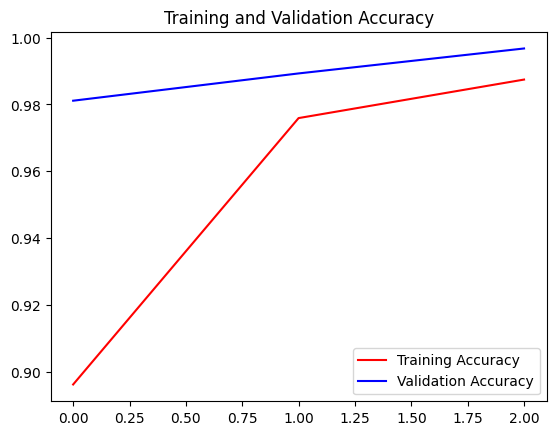

<Figure size 640x480 with 0 Axes>

In [36]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

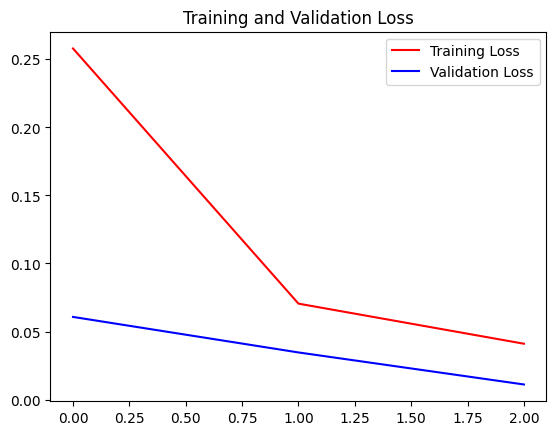

<Figure size 640x480 with 0 Axes>

In [37]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

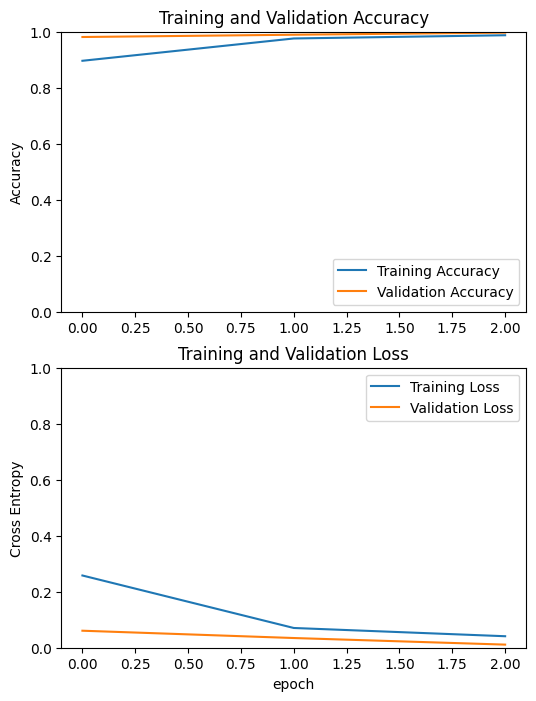

In [38]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: tea bird eye spot-augmented
2/2 [==============================] - 2s 16ms/step
predicted label: tea bird eye spot-augmented


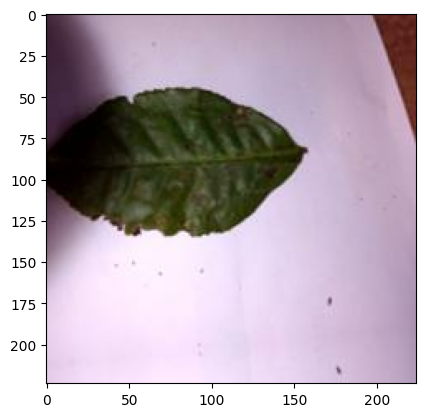

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model5.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [40]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


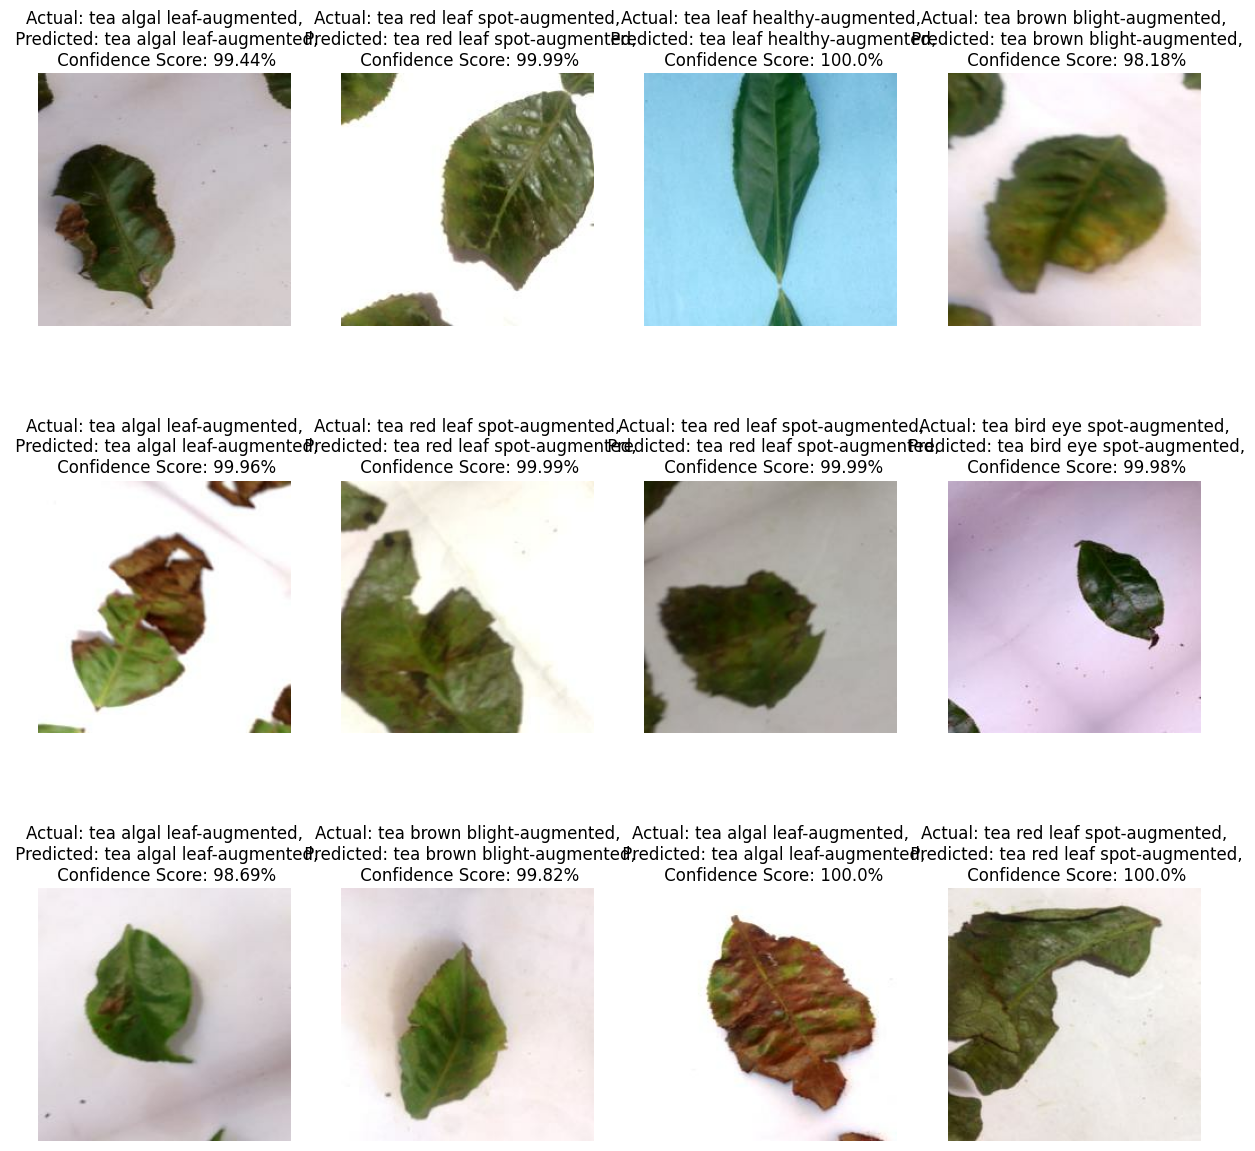

In [41]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [42]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 21ms/step


In [43]:
act_class

['tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea algal leaf-augmented',
 'tea brown blight-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea algal leaf-augmented',
 'tea red leaf spot-augmented',
 'tea anthracnose-augmented',
 'tea bird eye spot-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea red leaf spot-augmented',
 'tea algal leaf-au

In [44]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [45]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

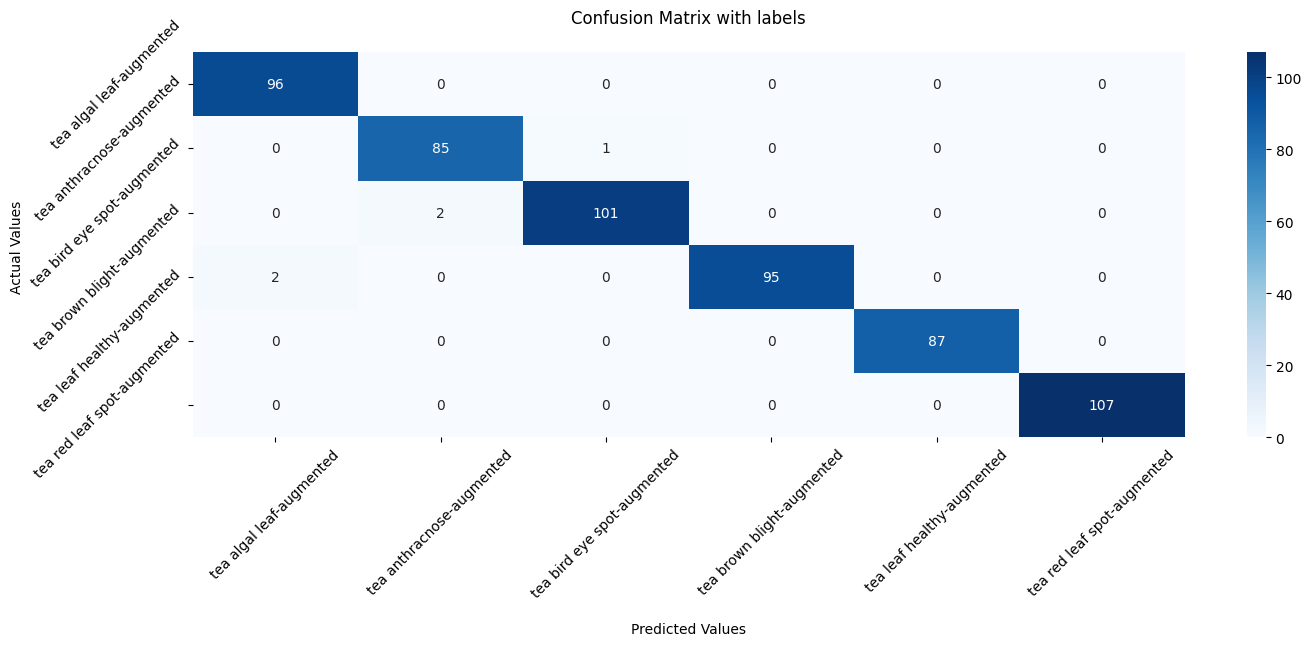

In [46]:
plot_confusion_matrix(cm = cm, classes = classes)

In [47]:
def saved_model(model_path, modelname, model):
  export_path = os.path.join(model_path, modelname)
  model.save(export_path)
  #tf.saved_model.save(model, export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# function to saved_model_history
def saved_model_history(model_path, modelname, history):
  with open(os.path.join(model_path, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# function to save tflite
def tflite_model_convert(model_path, tflite_path, modelname):

  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(model_path, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_path, "{}".format(modelname))

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "{}.tflite".format(modelname))
  
  label_file = os.path.join(tflite_dir, "{}.txt".format(modelname))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [48]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_model"
os.makedirs(model_path, exist_ok=True)
modelname = "ResNet50_tea"
saved_model(model_path, modelname, model5)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_model/ResNet50_tea
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [49]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_histori"
os.makedirs(model_path, exist_ok=True)
modelname = "ResNet50_tea"
saved_model_history(model_path, modelname, history5)

In [50]:
# pemanggilan fungsi tflite
model_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_model"
modelname = "ResNet50_tea"
tflite_path = "/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_tflite"
os.makedirs(tflite_path, exist_ok=True)

tflite_model_convert(model_path, tflite_path, modelname)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_tflite/ResNet50_tea
['ResNet50_tea.tflite', 'ResNet50_tea.txt']


In [53]:
model5 = tf.keras.models.load_model('/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/saved_model/ResNet50_tea')

Saving antharacnose tea.jpg to antharacnose tea.jpg
1/1 [==============================] - 1s 977ms/step
predictions :  [[4.0231585e-03 8.8795173e-01 1.0432272e-01 1.5962877e-03 1.3724349e-03
  7.3370471e-04]]
predicted label: tea anthracnose-augmented


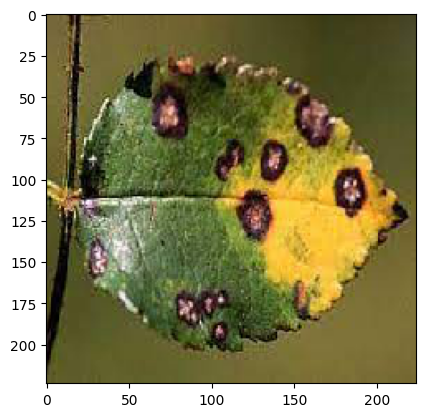

In [54]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving tea algal leaf.jpg to tea algal leaf.jpg
1/1 [==============================] - 0s 24ms/step
predictions :  [[0.00539046 0.04568544 0.15446505 0.00267111 0.00583434 0.7859535 ]]
predicted label: tea red leaf spot-augmented


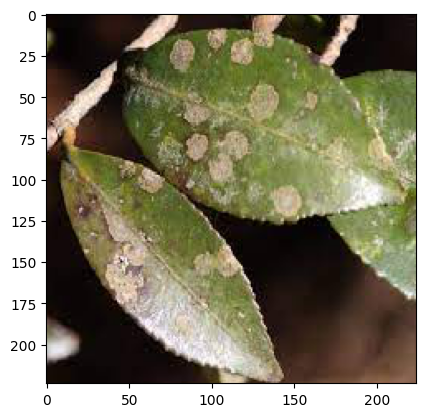

In [55]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])